In [131]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

c:\Users\Mehta\Desktop: ['932c3979-4c5d-4898-be09-ff2c099eca11.pdf', 'ardtdt', 'Assesment', 'desktop.ini', 'Discord.lnk', 'Internship Code', 'ML+Cheat+Sheet_2.pdf', 'PPT Assignments', 'Programming Assignment', 'Python Programming', 'VALORANT.lnk', 'Zoom.lnk']
c:\Users\Mehta\Desktop\Internship Code: ['.git', '.gitignore', 'code.ipynb', 'data.pickle', 'RELIANCE.NS (1).csv', 'RELIANCE.NS (2).csv', 'requiremets.txt', 'setup.py', '^NSEI.csv']


In [133]:
# import all stock prices 
df = pd.read_csv("^NSEI.csv", index_col = 0)
df = df.dropna()
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])


<class 'pandas.core.frame.DataFrame'>
Index: 3012 entries, 9/17/2007 to 1/20/2020
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  3012 non-null   object 
 1   open    3012 non-null   float64
 2   high    3012 non-null   float64
 3   low     3012 non-null   float64
 4   close   3012 non-null   float64
 5   volume  3012 non-null   float64
dtypes: float64(5), object(1)
memory usage: 164.7+ KB

number of different stocks:  1
['EQIX']


In [148]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = numpy.asarray(stock)# convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data)
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]
# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'high', 'low', 'close']
x_train.shape =  (2394, 19, 4)
y_train.shape =  (2394, 4)
x_valid.shape =  (299, 19, 4)
y_valid.shape =  (299, 4)
x_test.shape =  (299, 19, 4)
y_test.shape =  (299, 4)


C:\Users\Mehta\AppData\Local\Temp\ipykernel_17396\1210973616.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_stock.drop(['symbol'],1,inplace=True)
C:\Users\Mehta\AppData\Local\Temp\ipykernel_17396\1210973616.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_stock.drop(['volume'],1,inplace=True)


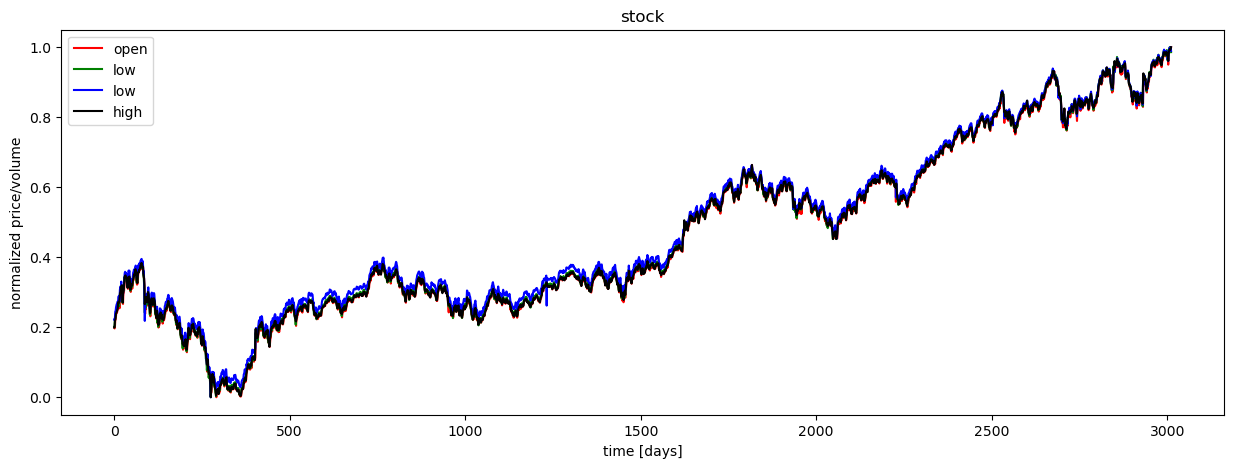

In [149]:
plt.figure(figsize=(15, 5))
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [162]:
import tensorflow as tf
import numpy as np

index_in_epoch = 0
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# Function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size

    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)  # Shuffle permutation array
        start = 0  # Start next epoch
        index_in_epoch = batch_size

    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# Parameters
n_steps = seq_len - 1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(shape=[None, n_steps, n_inputs], dtype=tf.float32)
y = tf.compat.v1.placeholder(shape=[None, n_outputs], dtype=tf.float32)

# Define RNN cells
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for _ in range(n_layers)]

multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)

rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:, n_steps - 1, :]

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Run the graph
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs * train_set_size / batch_size)):
        x_batch, y_batch = get_next_batch(batch_size)
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if iteration % int(5 * train_set_size / batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f' % (
                iteration * batch_size / train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Mehta\AppData\Local\Temp\ipykernel_17396\2555552559.py:41: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
C:\Users\Mehta\AppData\Local\Temp\ipykernel_17396\2555552559.py:49: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)


0.00 epochs: MSE train/valid = 0.688319/0.876832
4.99 epochs: MSE train/valid = 0.000181/0.000377
9.98 epochs: MSE train/valid = 0.000133/0.000270
14.97 epochs: MSE train/valid = 0.000128/0.000182
19.97 epochs: MSE train/valid = 0.000082/0.000135
24.96 epochs: MSE train/valid = 0.000088/0.000210
29.95 epochs: MSE train/valid = 0.000068/0.000111
34.94 epochs: MSE train/valid = 0.000067/0.000135
39.93 epochs: MSE train/valid = 0.000060/0.000104
44.92 epochs: MSE train/valid = 0.000061/0.000120
49.92 epochs: MSE train/valid = 0.000055/0.000088
54.91 epochs: MSE train/valid = 0.000051/0.000067
59.90 epochs: MSE train/valid = 0.000079/0.000223
64.89 epochs: MSE train/valid = 0.000053/0.000167
69.88 epochs: MSE train/valid = 0.000058/0.000118
74.87 epochs: MSE train/valid = 0.000047/0.000086
79.87 epochs: MSE train/valid = 0.000052/0.000079
84.86 epochs: MSE train/valid = 0.000042/0.000078
89.85 epochs: MSE train/valid = 0.000045/0.000079
94.84 epochs: MSE train/valid = 0.000047/0.000055
99.

In [163]:
y_train.shape

(2394, 4)

correct sign prediction for close - open price for train/valid/test: 0.64/0.79/0.86


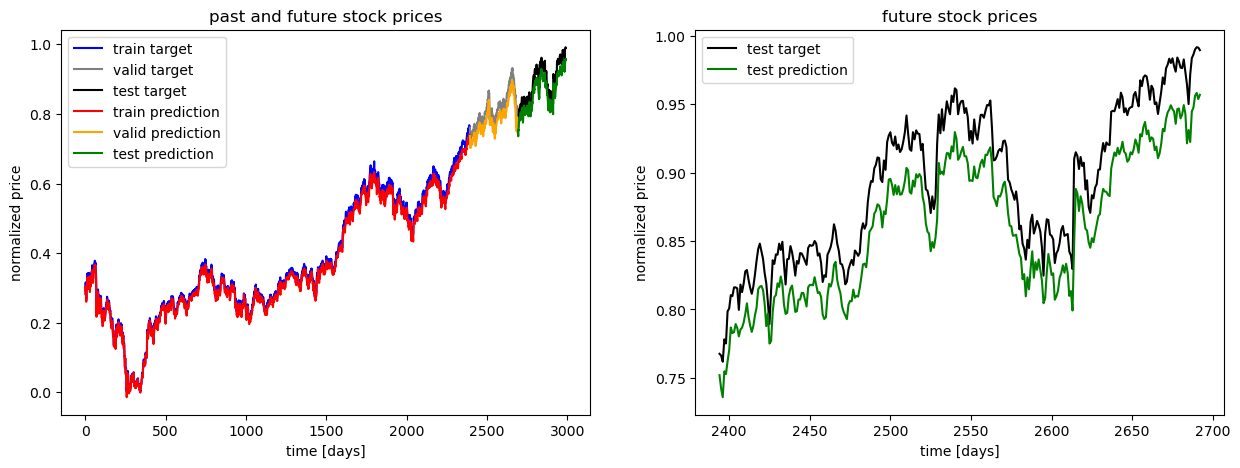

In [164]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')
plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))